# A tricky thing here is the difference between first visits and multiple visits essentially, because the animals have biases 


You could quantify this with a likelihood based approach. This would be the cleanest. You can calculate under.

In effect you don't need them to be making the correct decision at each point, you need them to be more likely to make the correct decision that when they are following a policy that leads them to the correct reward. This could change the results in either direction

You could also quantify this as being between having learned the correct policy and not.

## Analysing it more complicatedly


There are several ways of calculating this. Could compare this to the marginal distribution of all states. Could compare it to the marginal transition matrix.

Ok, so the answer here is complicated. What we therefore need to do is quantify the biases. 

- Quantify stability of biases within session
- Quantify the stability of across session biases
- Quantify these conditional on reward location

My sense is to compare it to the transition matrix distribution calculated for the reward location that preceeded the trial across the entire session


## Unaswered questions

 - What is the null distribution, when you don't directly calculate fraction correct but calculate it against the empirical transition probabilities.
 - What do you do about transitions where in states that were rewarded??
 
 The null hypothesis is that the data
 
 
Really need to think carefully about how to rule out that this is driven by one step transitions

In [ ]:
%matplotlib inline
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn
import scipy.stats as stt
seaborn.set(font_scale=1.5,style='ticks')
import os
import re
import sys
import itertools
import functools
import networkx as nx
from datetime import date, timedelta
from datetime import datetime

sys.path.append(r"C:\Users\yweissenberger\Documents\code\line_loop-master")
sys.path.append(r"C:\Users\yweissenberger\Documents\code\line_loop-master\packages")
sys.path.append("/Users/yves/Documents/Code/line_loop/packages/")

In [6]:
import mouse_poker as mpk

In [7]:
#physical position of the pokes. In terms of numbering, the pokes are numbered as follows
#(or in some cases the indexing starts from 0 rather than 1)

"""
     1
   2   3
 4   5   6 
   7   8
     9
"""

#physical positions of the pokes, used for drawing the graphs
#with nodes and edges. The distances here are to scale with
#the real thing.
poke_pos = [ [149,0],
         [68,19],[231,19],
       [0,62],[149,62],[298,62],
         [68,105],[231,105],
              [149,124]]

In [8]:
from mouse_poker.navi import *

# Helper functions

In [36]:
def get_st_dist(state_seq,pk_ctr,rew_loc):
    """ get distances between current and next state and reward during navigation on the line """
    
    d0 = np.abs(state_seq[pk_ctr]-rew_loc)
    d1 = np.abs(state_seq[pk_ctr+1]-rew_loc)
    st_dist = state_seq[pk_ctr]-state_seq[pk_ctr+1]
    
    return d0,d1,st_dist
    

In [688]:
def policy_changed_with_rew_loc(state_seq,rew_loc,prev_diff_rew_loc):
    
    if prev_diff_rew_loc!=None:
        same_as_prev_pol = (((state_seq[pk_ctr]-rew_loc)>0)==           #direction to reward with location
                            ((state_seq[pk_ctr]-prev_diff_rew_loc)>0))  #direction to reward with prev location
    else:
        same_as_prev_pol = False
    
    if state_seq[pk_ctr]==prev_diff_rew_loc:
        same_as_prev_pol = True
    return same_as_prev_pol

# Load the dataz

In [689]:

#f = open("/Users/yves/Documents/beh_dat_new_room/line_loop_batch_3NAVI/'460175_10'-2021-03-15-145534.txt",'r')
#f = open("/Users/yves/Documents/beh_dat_new_room/line_loop_batch_3NAVI/'460175_10'-2021-03-01-110337.txt",'r')
#f = open("/Users/yves/Documents/beh_dat_new_room/line_loop_batch_3NAVI/'456675_10'-2021-02-23-142909.txt",'r')

lines =f.readlines()
experiment_name, task_name, subject_id, task_nr, graph,lineloop,date,test,_ = mpk.load.get_metadata(lines)
dat_dict,events,event_times,nRews,_ = mpk.load.parse_data(lines,experiment_name)

print("rewards_received: {:d}".format(nRews))
print('task_nr:{:.0f}'.format(int(task_nr)))

IndexError: list index out of range

In [690]:
ROOT = '/Users/yves/Documents/beh_dat_new_room/line_loop_batch_4_RUNNAVI/'
allFs = [os.path.join(ROOT,i) for i in os.listdir(ROOT)]
allFs = [i for i in allFs if not os.path.isdir(i)]

In [691]:
#this extracts the core information from the text file. This is key to work with
state_seq, rew_list, port_seq,forced_seq = extract_navi_dat(lines)

#this runs the main analysis that we have done so far.
#perf,perf_ctr = get_performance(state_seq,rew_list,port_seq,forced_seq,rew_indices,map_poke_to_state,minNrew=0)
#fc = perf/perf_ctr  #calculate fraction correct at each point
#print(np.nanmean(fc))

In [692]:
f = open(allFs[2],'r')
lines =f.readlines()
state_seq, rew_list, port_seq,forced_seq = extract_navi_dat(lines)
print(sum(rew_list))

1


In [693]:
prev_rew_loc = None  #this is the reward location that was last updated
direction = None
perf = 0
trial_ctr = 0
has_updated = False


rewarded_pokes = np.concatenate([[0],np.where(rew_list)[0]])
trial_starts = rewarded_pokes[:-1]
trial_ends = rewarded_pokes[1:]
rewarded_states = np.concatenate([np.array(state_seq)[trial_starts]])
same_as_prev_pol = True
exp_dirs = []
verbose = True
prev_rew_loc = None

#this is the start of a 
for rew_ctr,(st,nd) in enumerate(zip(trial_starts,trial_ends)):

    rew_loc = state_seq[nd]  #this is state that is rewarded
    #print(state_seq[nd])  #this is the first state the animals enter into
    prev_direction = direction
    
    if rew_loc!=prev_rew_loc:
        #print("HERE")
        direction = None
        has_updated = False
        prev_direction = None
        exp_dirs = [] #experienced directions
        prev_diff_rew_loc = prev_rew_loc
    
    
    direction = (rew_loc - state_seq[st+1])>0 #which side are you approaching the reward from
    hasbeenat = []
    for pk_ctr in range(st+1,nd):  #for each poke between two rewards  
        
        d0,d1,st_dist = get_st_dist(state_seq,pk_ctr,rew_loc)
        free_choice_trial = forced_seq[pk_ctr]==False
        state = state_seq[pk_ctr]
        same_as_prev_pol = policy_changed_with_rew_loc(state_seq,rew_loc,prev_diff_rew_loc)
        
        update_condition_list = [free_choice_trial,                 #NOT a forced trial
                                 #prev_diff_rew_loc is not None,    #hash-out if want to look include very first block in session
                                 not same_as_prev_pol,              #ensure that this a policy change is required to make correct decision
                                 prev_direction is not None,        #make sure NOT looking at first run-to-rew after a block transition (when rew_loc is unknown)
                                 direction not in exp_dirs,         #hasn't experienced this direction in this block yet
                                 #not has_updated,                  #toggle if only look at first relevant POKE in block
                                 state not in hasbeenat
                                ]
        print(update_condition_list,direction,exp_dirs,rew_loc)
        if all(update_condition_list):
            if verbose:
                print(("!"*80 + "\n")*3)


            perf += (d1<d0)
            trial_ctr += 1

            has_updated = True  #if decisions from this block have led to updated

        hasbeenat.append(state)
    if direction not in exp_dirs:
        exp_dirs.append(direction)
    prev_rew_loc = rew_loc


[False, True, False, True, True] False [] 5
[False, True, False, True, True] False [] 5
[False, True, False, True, True] False [] 5
[False, True, False, True, True] False [] 5
[False, True, False, True, True] False [] 5
[False, True, False, True, True] False [] 5
[False, True, False, True, True] False [] 5


In [694]:
perf

0

In [939]:
#ROOT = '/Users/yves/Documents/beh_dat_new_room/line_loop_batch_4_RUNNAVI/'

#ROOT = '/Users/yves/Documents/behavior_data/line_loop_cohort_1/line_loop_batch_4_RUNNAVI/'
ROOT = '/Users/yves/Documents/beh_dat_new_room/line_loop_batch_3NAVI/'
#ROOT = '/Users/yves/Documents/beh_dat_new_room/line_loop_batch_3NAVI_toLOOP//'

allFs = [os.path.join(ROOT,i) for i in os.listdir(ROOT)]
allFs = [i for i in allFs if not os.path.isdir(i)]

In [933]:
#allFs = [i for i in allFs if '460175' in i]
allFs = [i for i in allFs if '456675' in i]

# Batch Version 

Checks that I have run on this code:

- Ensure that distances between states within a trial is always equal to 1

In [1054]:
def get_transition_matrix(state_seq,rew_list,forced_seq,minNrew=0,set_rew_indices=None,firstOnly=False):
    """ This function obtains empirical counts for transitions from a given state to another
        as a function of """
    #used_states = sorted([i[1] for i in map_poke_to_state.args[0]])
    if set_rew_indices is None: set_rew_indices=list(range(9))
    perf = np.zeros([9,9,9])
    perf_ctr = np.zeros([9,9,9])
    rew_hist = []
    transition_counts = np.zeros([9,9,9])
    state_ctr = np.zeros([9,9])
    all_rew_loc = []
    for rew_ctr,(st,nd) in enumerate(zip(np.where(rew_list)[0][:-2],np.where(rew_list)[0][1:-1])):
        #print(1)
        rew_loc = state_seq[nd]
        if (rew_loc in set_rew_indices):
            all_rew_loc.append(rew_loc)
            if not rew_hist:
                rew_hist.append(rew_loc)
            elif rew_loc==rew_hist[-1]:
                rew_hist.append(rew_loc)
            else:
                rew_hist = []

            has_visited= []
            if len(rew_hist)>minNrew:

                for pk_ctr in range(st+1,nd):
                    if not forced_seq[pk_ctr]:
                        state = state_seq[pk_ctr]
                        if state not in has_visited:

                            next_state = state_seq[pk_ctr+1]
                            if rew_loc==3:
                                print(state,next_state)

                            transition_counts[state,next_state,rew_loc] += 1
                            state_ctr[state,rew_loc] += 1
                            if firstOnly: has_visited.append(state)

        transition_mtx = np.array([(transition_counts/state_ctr[:,None])[:,:,i]
                           for i in range(9)])
        state_ctr = np.array([state_ctr[:,i] for i in range(9)])

    return transition_mtx, transition_counts, state_ctr, np.unique(all_rew_loc)

In [1050]:
trial_starts

array([  0,   4,   6,   9,  11,  18,  24,  26,  37,  44,  49,  59,  62,
        65,  69,  76,  92,  95,  98, 104, 106, 111, 147, 155, 164, 167,
       169, 171, 176, 181, 188, 194, 199, 201, 203, 206, 208, 212, 215,
       217, 220, 224, 228, 230, 233, 236, 238, 266, 268, 270, 279, 282,
       289, 291, 296, 298, 301, 330, 347, 363, 366, 369, 372, 378, 388,
       415, 418, 420, 435, 441, 456, 459, 464, 466, 468, 470, 472, 474,
       483, 486, 490, 492, 501, 503, 506, 508, 513, 547, 581, 587, 589,
       602, 608, 610, 612, 614, 618, 622, 626, 628, 630, 633, 637, 641,
       643, 645, 647, 649, 651, 681, 692, 694, 699, 702, 704, 706, 711,
       716, 718, 723, 725, 730, 734, 746, 748, 751, 754, 758, 760, 764,
       768, 773, 808, 820, 823, 827, 832, 835, 838, 848, 853, 856, 859,
       861, 869, 871, 873, 878])

In [1051]:
len(state_seq)

887

In [1055]:
a,b,c,d = get_transition_matrix(state_seq,
                rew_list,
                forced_seq)

8 7
7 8
7 6
6 7
7 6
6 7
7 6
6 5
5 4
4 3
5 4
4 3
6 5
5 4
4 3
7 6
6 5
5 4
4 3
5 4
4 3
5 4
4 3
8 7
7 8
7 6
6 5
5 6
6 5
5 4
4 3
7 6
6 5
5 4
4 3
5 4
4 3
5 4
4 3
4 3
8 7
7 8
7 6
6 5
5 4
4 3
4 3
4 3
7 6
6 5
5 4
4 3


/Users/yves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in true_divide
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide


In [1056]:
a[:,:,3]

array([[       nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan],
       [       nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan],
       [       nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan],
       [       nan,        nan,        nan,        nan, 1.66666667,
        0.        , 0.        , 0.        , 0.        ],
       [       nan,        nan,        nan, 0.        , 0.2       ,
        0.        , 0.        , 0.        , 0.        ],
       [       nan,        nan,        nan, 0.        , 0.42105263,
        0.        , 0.        , 0.        , 0.        ],
       [       nan,        nan,        nan, 0.        , 1.        ,
        0.        , 0.        , 0.        , 0.        ],
       [       nan,        nan,        nan, 0.        , 0.04      ,
        0.        , 0.        , 0.        , 0.        ],


In [1060]:
a[3]

array([[       nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan],
       [       nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan],
       [       nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan],
       [       nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan],
       [0.        , 0.        , 0.        , 1.66666667, 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 1.2       ,
        0.        , 0.1       , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.66666667, 0.        , 0.16666667, 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 1.        , 0.        , 0.375     ],


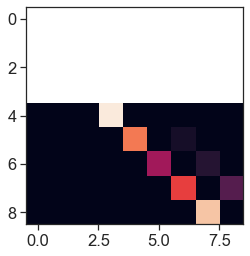

In [1059]:
plt.imshow(a[3])

In [1000]:
verbose = False
perf = 0
trial_ctr = 0

check1 = []
for fpath in allFs[:3]:

    f = open(fpath,'r')
    lines =f.readlines()
    state_seq, rew_list, port_seq,forced_seq = extract_navi_dat(lines)
    prev_rew_loc = None  #this is the reward location that was last updated
    direction = None
    has_updated = False

    rewarded_pokes = np.concatenate([[0],np.where(rew_list)[0]])
    trial_starts = rewarded_pokes[:-1]
    trial_ends = rewarded_pokes[1:]
    rewarded_states = np.concatenate([np.array(state_seq)[trial_starts]])
    same_as_prev_pol = True
    exp_dirs = []
    verbose = True
    prev_rew_loc = None

    #this is the start of a 
    for rew_ctr,(st,nd) in enumerate(zip(trial_starts,trial_ends)):

        rew_loc = state_seq[nd]  #this is state that is rewarded
        #print(state_seq[nd])  #this is the first state the animals enter into
        prev_direction = direction

        if rew_loc!=prev_rew_loc:
            #print("HERE")
            direction = None
            has_updated = False
            prev_direction = None
            exp_dirs = [] #experienced directions
            prev_diff_rew_loc = prev_rew_loc


        direction = (rew_loc - state_seq[st+1])>0 #which side are you approaching the reward from
        visited_states = []
        #print(state_seq[st],state_seq[st+1])
        start_state_trial = state_seq[st+1]
        for pk_ctr in range(st+1,nd):  #for each poke between two rewards  

            d0,d1,st_dist = get_st_dist(state_seq,pk_ctr,rew_loc)
            free_choice_trial = forced_seq[pk_ctr]==False
            state = state_seq[pk_ctr]
            same_as_prev_pol = policy_changed_with_rew_loc(state_seq,rew_loc,prev_diff_rew_loc)
            check1.append(st_dist)
            update_condition_list = [free_choice_trial,              #NOT a forced trial
                                     prev_diff_rew_loc is None,  #hash-out if want to look include very first block in session
                                     not same_as_prev_pol,           #ensure that this a policy change is required to make correct decision
                                     prev_direction is not None,     #make sure NOT looking at first run-to-rew after a block transition (when rew_loc is unknown)
                                     direction not in exp_dirs,      #hasn't experienced this direction in this block yet
                                     #not has_updated,               #toggle if only look at first relevant POKE in block
                                     #state not in visited_states,    #look only at first visits to each state
                                     #d0>1,
                                     #np.abs(start_state_trial-rew_loc)>1,
                                     state !=rew_loc
                                    ]

            #if pk_ctr<60:
            #    print(update_condition_list,direction,exp_dirs,state,rew_loc,pk_ctr,os.path.split(fpath)[-1])
            if all(update_condition_list):
                if verbose:
                    print(("!"*80 + "\n")*3)
                    print('state:{},nextstate:{},rew_loc:{},correct:{}'.format(state,state_seq[pk_ctr+1],rew_loc,int(d1<d0)))
                    print(pk_ctr,os.path.split(fpath)[-1])
                    print(state_seq[st+1:nd+1])
                    print('\n')

                perf += int(d1<d0)
                trial_ctr += 1

                has_updated = True  #if decisions from this block have led to updated

            visited_states.append(state)

        if direction not in exp_dirs:
            exp_dirs.append(direction)
        prev_rew_loc = rew_loc


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

state:7,nextstate:6,rew_loc:6,correct:1
8 '460175_10'-2021-03-15-145534.txt
[6, 7, 6]




In [957]:
#in looking at the first block of the session, in a length 6 line, you can only look at rewards that are located
#at positions 3 and 4, not at 1 and 2 and not at 5 and 6. Thus you should have 1/3 as many trials as you have sessions...

In [958]:
perf/trial_ctr

0.5925925925925926

In [959]:
perf

16

In [960]:
trial_ctr



27

In [961]:
stt.binom_test(perf,trial_ctr,p=0.5)

0.44206833839416504

# Old Version